# Transverse field ising models to demo primitives

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuits(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else: 
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    
    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    #Adding Rzz gates in the even layers
    for i in range(0, qc.num_qubits-1, 2): 
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
            qc.barrier()
    #Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2): 
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
            qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
            qc.barrier()

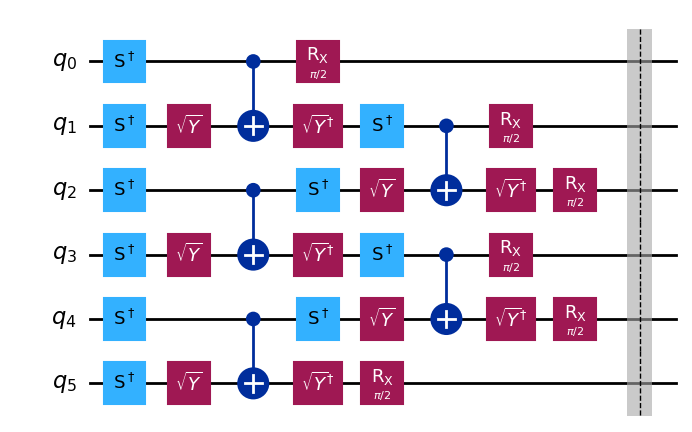

In [2]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuits(num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output='mpl', fold=-1)

# Demo: Sampler 

In [3]:
def append_mirrored_1d_tfim_circuits(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    #Adding Rzz gates in the odd layers
    for i in range(1, qc.num_qubits-1, 2): 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
            qc.barrier()
    #Adding Rzz gates in the even layers
    for i in range(0, qc.num_qubits-1, 2): 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
            qc.barrier()

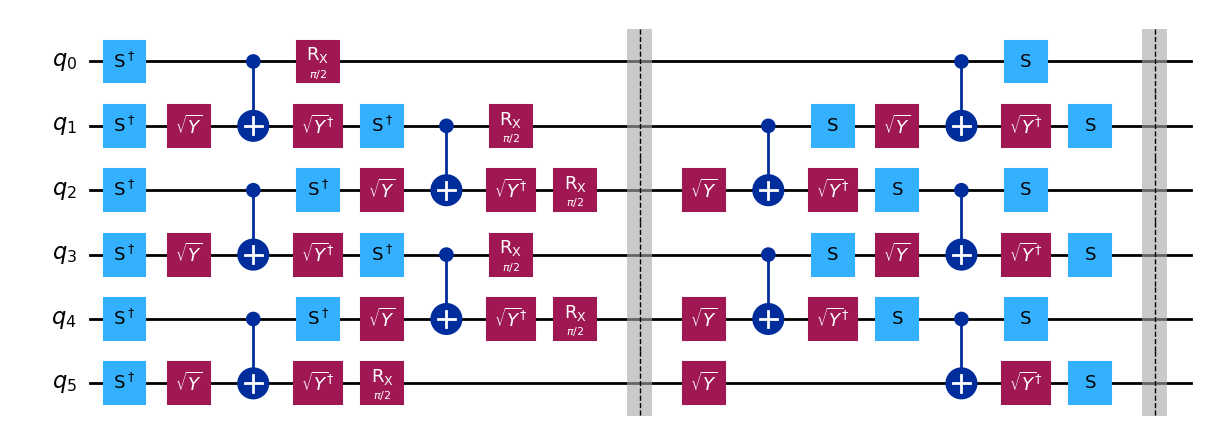

In [4]:
append_mirrored_1d_tfim_circuits(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output='mpl', fold=-1)

# Step 1: Map the problem to circuits and observables

In [5]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuits(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers = True, layer_barriers = True)
    append_mirrored_1d_tfim_circuits(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

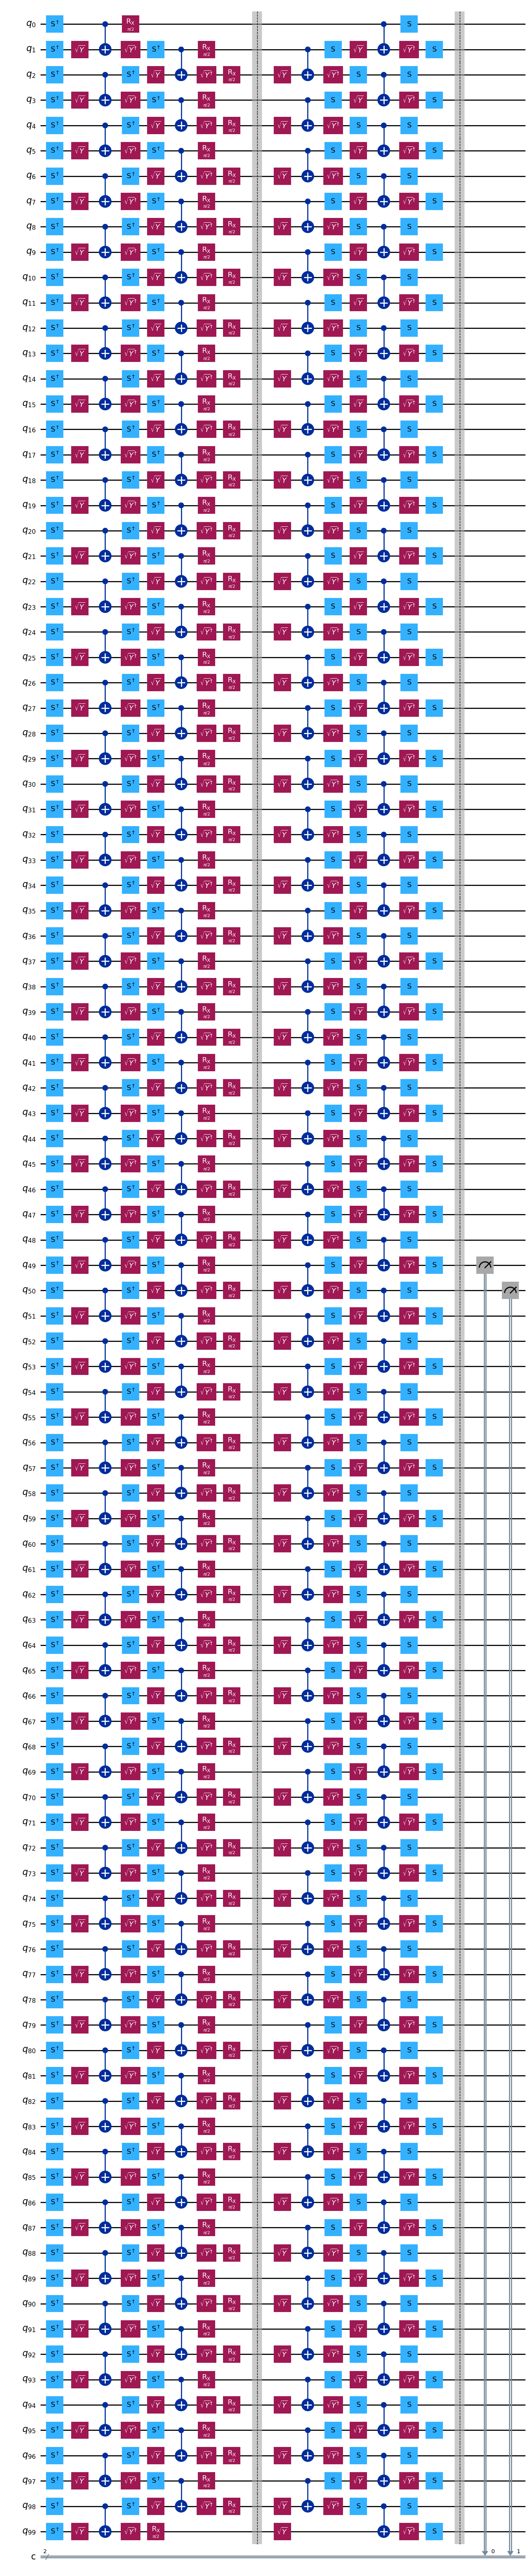

In [6]:
qc_list[1].draw(output='mpl')

# Step 2: Optimize 

In [7]:
from qiskit import transpile 
from qiskit_ibm_runtime import QiskitRuntimeService 

backend_name = "ibm_kyoto"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print("Done getting the backend")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_64998/4077778104.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend(backend_name)


Done getting the backend


# Step 3: Execute on Hardware 

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler 

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True 
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_64998/3235401922.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


ctv2cq246w90008rbjxg


# Step 4: Post-processing and Plotting 

In [11]:
job_id = "ctv2cq246w90008rbjxg"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try: 
        data = job.result()[trotter_step].data 
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

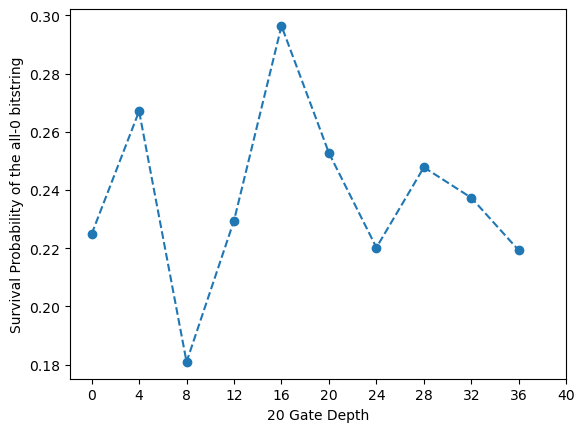

In [13]:
import matplotlib.pyplot as plt 

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('20 Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()

# Estimator 

# Step 1: Mapping the problem 

In [16]:
from qiskit.circuit import Parameter 
rx_angle = Parameter("rx_angle")
trotter_steps = 2
qc = generate_1d_tfim_circuits(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

# Step 2: Optimize the circuit 

In [17]:
from qiskit import transpile 
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_osaka'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_64998/3525598973.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend(backend_name)


# Step 3: Execution on quantum hardware

In [18]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0 
max_rx_angle = np.pi/2
num_rx_angle = 12 
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True 
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend=backend, options=options)

job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_64998/3892042679.py:13: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(backend=backend, options=options)


ctv3xwf3zkm0008sfdbg


# Step 4: Post-processing and plotting

(-0.1, 1.1)

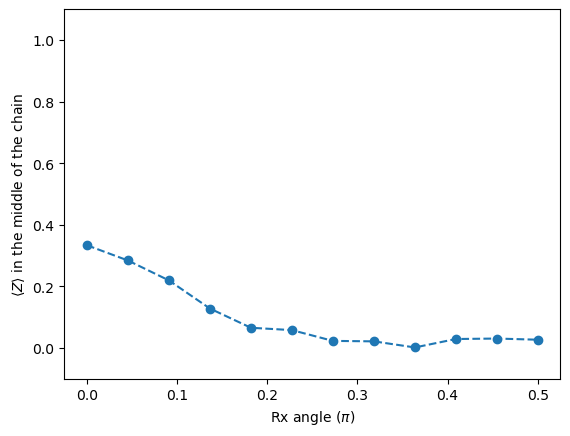

In [23]:
job_id = "ctv3xwf3zkm0008sfdbg"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 1.1)